In [196]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

In [197]:
%run optimization_criterions.ipynb

In [198]:
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    # Obtener portfolio
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df_portfolio = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df_portfolio = pd.concat([df_portfolio, temp_df], axis=1)
    df_portfolio.index.names = ['time']
    df_portfolio.index = pd.to_datetime(df_portfolio.index, unit='s')
    df_portfolio = np.log(df_portfolio).diff().dropna()
    # Obtener índice de referencia
    data_index = mt5.copy_rates_range('SP500', mt5.TIMEFRAME_D1, time_from, time_to)
    df_index = pd.DataFrame(data_index['close'], index=data_index['time'], columns=['index'])
    df_index = np.log(df_index).diff().dropna()
    df_index.index.names = ['time']
    df_index.index = pd.to_datetime(df_index.index, unit='s')


In [199]:
# Encontrar el número de activos
n = df_portfolio.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución de los problemas de optimización
res_MV = minimize(SOR_criterion, x0, 
                  method = 'SLSQP',
                  args=(df_portfolio),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.08302662204916356
            Iterations: 13
            Function evaluations: 1313
            Gradient evaluations: 13


<Axes: >

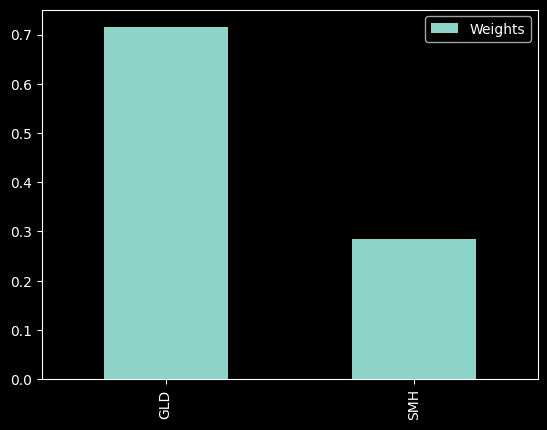

In [200]:
# De los activos seleccionados, selecciono los que más pesos tengan en la cartera
df_weights = pd.DataFrame(X_MV, index=list_tickers, columns=['Weights'])
df_weights = df_weights.loc[df_weights["Weights"] > np.mean(df_weights["Weights"].values)]
df_weights.plot(kind='bar')

<Axes: >

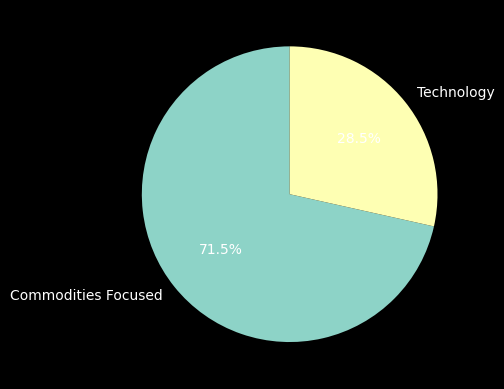

In [201]:
# Visualización de la distribución sectorial
tickers = yf.Tickers(df_weights.index.to_list())
tickers_type = dict()
for key, value in tickers.tickers.items():
    tickers_type[key] = value.info['category']
tickers_category = pd.DataFrame.from_dict(tickers_type, orient='index', columns=['category'])
df_category_weight = pd.concat([tickers_category, df_weights], axis=1)
df_category_weight.groupby('category').sum()['Weights'].plot(kind='pie', 
                                                             autopct='%1.1f%%', 
                                                             startangle=90, 
                                                             ylabel='')

<Axes: title={'center': 'Beta: 0.44 | Alpha: 0.10'}, xlabel='Tiempo anualizado', ylabel='Retornos %'>

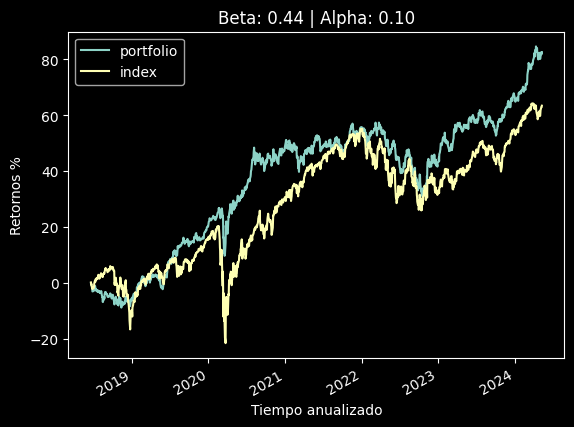

In [202]:
# Se calcula la rentabilidad de la cartera según el peso de cada activo
df_port = (pd.DataFrame(
    np.sum(
        np.multiply(
            df_portfolio[df_weights.index.to_list()].values,
            np.transpose(df_weights['Weights'].values)), 
        axis=1),
    index=df_portfolio.index,
    columns=['portfolio'])
)
df_index = df_index.loc[df_port.index[0]:df_port.index[-1]]
# Cálculo de los valores CAMP de la cartera
beta = beta_function(df_port, df_index)
alpha = alpha_function(df_port, df_index)
# Visualización del rendimiento
df_port_index = pd.concat([df_port, df_index], axis=1).cumsum(axis=0).multiply(100., axis=0).dropna()
df_port_index.plot(
    title=f"Beta: {beta:.2f} | Alpha: {alpha:.2f}",
    ylabel="Retornos %",
    xlabel="Tiempo anualizado")

In [203]:
ratio_sharpe = sharpe_function(df_port)
ratio_sortino = sortino_function(df_port)
print(f"Ratio de Sharpe: {ratio_sharpe} \n"
      f"Ratio de Sortino: {ratio_sortino}")

Ratio de Sharpe: 0.9495435541764009 
Ratio de Sortino: 1.3180067648390545


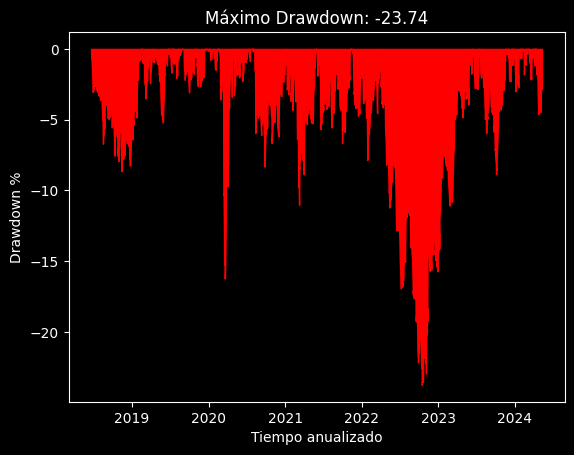

In [204]:
portfolio_drawdown = drawdown_function(df_port)
max_portfolio_drawdown = np.min(portfolio_drawdown) * 100
plt.fill_between(portfolio_drawdown.index, portfolio_drawdown.iloc[:, 0] * 100, color='red')
plt.title(f"Máximo Drawdown: {max_portfolio_drawdown:.2f}")
plt.ylabel("Drawdown %")
plt.xlabel("Tiempo anualizado")
plt.show()